In [115]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import scipy

In [116]:
## load .npy data
X = np.load('../data/X_example.npy',allow_pickle=True)
X.shape

(45, 100)

In [117]:
X

array([[0.22489321, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.7751068 , 0.38622263, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.61377734, 0.54755205, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [118]:
def construct_X(M, alphas, Np=None):
    '''
    Np - # sensors
    N - # Np * No = len(alphas) * Np
    M - tomogram size
    D - M * M
    '''
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
    
    D = M * M
    N = len(alphas) * Np
    
    C = np.mgrid[0:M, 0:M]
    # print(type(C))
    C = np.array([C[1],C[0]]) ## changes in C[0] only influence the first alpha
    C = C.reshape(2, -1)
    # print("C shape is: ", C[0])
    
    i_indices = []
    j_indices = []
    weights = []
    
    for idx, alpha in enumerate(alphas):
        rad = np.deg2rad(alpha)
        n = np.array([np.cos(rad), np.sin(rad)])
        
        p = n.T @ C
        
        p += Np / 2  # shift to center sensor array
        # print("Shape of p is: ", p.shape) ## proiectia tuturor coordonatelor tomografului de MxM flattened pe normala data de alpha curent
        
        # print("P is ", p)

        ip_floor = np.floor(p).astype(int)
        ip_ceil = np.ceil(p).astype(int)
        
        valid_indices = (ip_floor >= 0) & (ip_floor < Np)
        valid_indices &= (ip_ceil >= 0) & (ip_ceil < Np)

        ip_floor = ip_floor[valid_indices]
        ip_ceil = ip_ceil[valid_indices]

        # print("-----")
        # print(ip_floor[0])
        # print(ip_ceil[0])

        pixel_indices = np.arange(D)[valid_indices]
        
        w_floor = 1 - (p[valid_indices] - ip_floor)
        w_ceil = 1 - w_floor

        # print("W floor is: ", w_floor)
        
        i_indices.extend((ip_floor + idx * Np).tolist())
        j_indices.extend(pixel_indices.tolist())
        weights.extend(w_floor.tolist())
        
        i_indices.extend((ip_ceil + idx * Np).tolist())
        j_indices.extend(pixel_indices.tolist())
        weights.extend(w_ceil.tolist())

    # X = scipy.sparse.coo_matrix((weights[::-1], (i_indices[::-1], j_indices[::-1])), shape=(N, D), dtype=np.float32)
    X = scipy.sparse.coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype=np.float32)
    
    return X

In [119]:
design_matrix = construct_X(10, [-33,1,42],15)
## convert to dense numpy array
design_matrix = design_matrix.toarray()

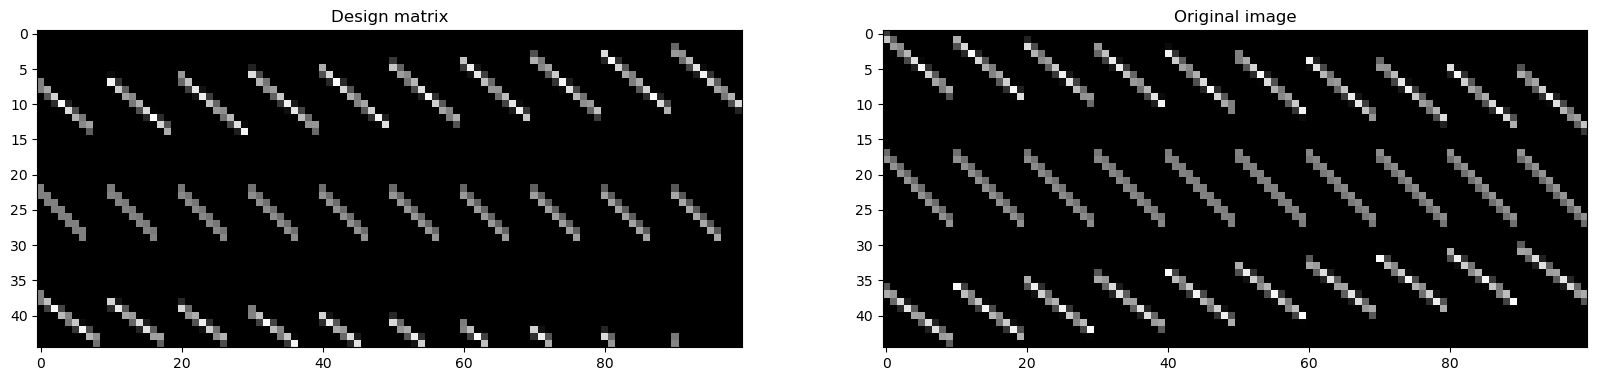

In [120]:
## plot them side by side
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(design_matrix, cmap='gray')
plt.title('Design matrix')
plt.subplot(1, 2, 2)
plt.imshow(X, cmap='gray')
plt.title('Original image')
plt.show()


#### Task 2

In [131]:
import scipy.sparse

M = 77 ## 195

## load the data
data_path = "../data/"

if M == 77:
    alphas = np.load(data_path + "alphas_77.npy",allow_pickle=True)
    y = np.load(data_path + "y_77.npy",allow_pickle=True)
    X = np.load(data_path + "X_77.npy",allow_pickle=True)
    X = scipy.sparse.csc_matrix(X.all())
else:
    alphas = np.load(data_path + "alphas_195.npy",allow_pickle=True)
    y = np.load(data_path + "y_195.npy",allow_pickle=True)
    # X = np.load(data_path + "X.npy",allow_pickle=True)


print(scipy.sparse.issparse(X))
print("Indices of non zero elements:",scipy.sparse.find(X)[0],scipy.sparse.find(X)[1])
print("Number of non zero elements:",X.nnz)
print("Sparsity measure:",X.nnz/(X.shape[0]*X.shape[1]))

<class 'numpy.ndarray'>
True
Indices of non zero elements: [  15   15   15 ... 9794 9794 9794] [ 0  1  2 ... 74 75 76]
Number of non zero elements: 1066978
Sparsity measure: 0.01834446316753001


In [133]:
print(X.shape,design_matrix.shape)
design_matrix = construct_X(M, alphas, Np=None)
design_matrix = scipy.sparse.csc_matrix(design_matrix)
print(type(design_matrix),type(X))

(9810, 5929) (9810, 5929)
<class 'scipy.sparse._csc.csc_matrix'> <class 'scipy.sparse._csc.csc_matrix'>


(5929,)


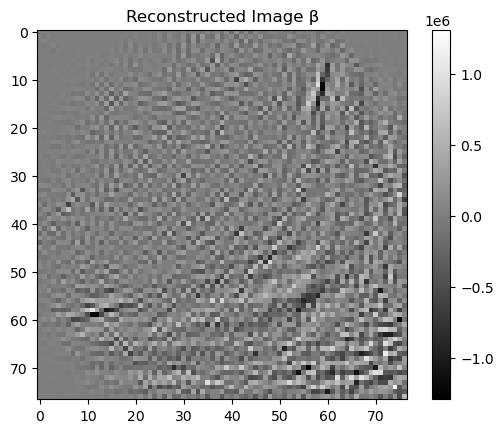

In [134]:
result = scipy.sparse.linalg.lsqr(design_matrix, y)
beta = result[0]
print(beta.shape)
M = 77
beta = beta.reshape(M,M)

# Visualize the reconstructed image
plt.imshow(beta, cmap='gray')
plt.title('Reconstructed Image β')
plt.colorbar()
plt.show()

#### Task 3

In [123]:
## empiricaly I can determine a lower number of alpha, but what would be an analytical optimum

def subsample_projections(alphas, y, num_projections):
    indices = np.linspace(0, len(alphas) - 1, num_projections, dtype=int)
    return alphas[indices], y[indices]

def reconstruct_image(alphas, y, num_projections, M, Np):
    # Subsample the projections
    alphas_sub, y_sub = subsample_projections(alphas, y, num_projections)
    
    # Construct the matrix X for the subsampled angles (this is a placeholder, actual construction of X will depend on specific implementation)
    X_sub = construct_X(M, alphas_sub)  # This function needs to be defined based on your specific implementation
    
    # Convert to sparse matrix
    X_sparse_sub = scipy.sparse.csc_matrix(X_sub)
    
    # Solve the least-squares problem
    result = scipy.sparse.lsqr(X_sparse_sub, y_sub)
    beta = result[0]
    
    # Reshape beta to the appropriate image dimensions
    beta_image = beta.reshape((M,M))
    
    return beta_image

In [ ]:
M = 77
Np = 109
num_projections_list = [10, 20, 30, 40, 50, 60, 70, 77]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, num_projections in enumerate(num_projections_list):
    beta_image = reconstruct_image(alphas, y, num_projections, M, Np)
    ax = axes[i // 4, i % 4]
    ax.imshow(beta_image, cmap='gray')
    ax.set_title(f'{num_projections} projections')
    ax.axis('off')

plt.tight_layout()
plt.show()
